In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import json
import nltk
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np
import seaborn as sns

In [7]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajaym\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
# def clean_text(text):
#     text = re.sub(r'(Item\s*\d+[A-Za-z]*)\.', r'\1. ', text)
#     text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
#     text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)
#     return text.strip()

def clean_text(text):
    # Replace \n with a space
    text = re.sub(r'\n', ' ', text)

    # Replace encoded apostrophes and quotes with plain text equivalents
    text = text.replace('\x92', "'")  # Right single quote
    text = text.replace('\x93', '"')  # Left double quote
    text = text.replace('\x94', '"')  # Right double quote
    text = text.replace('\xa0', ' ')  # Non-breaking space

    # Remove other \x.. sequences
    text = re.sub(r'\\x[0-9A-Fa-f]{2}', '', text)
    
    # Fix spacing issues around periods and capitalization
    text = re.sub(r'\s*\.\s*', '. ', text)
    text = re.sub(r'(Item\s*\d+[A-Za-z]*)\.', r'\1. ', text)
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
    text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)
    
    return text.strip()

In [43]:
def split_sentences_with_nltk(text):
    # Initial cleaning
    text = clean_text(text)

    # Use nltk's sentence tokenizer
    sentences = sentences = re.split(r'(?<=[.,;])\s*', text)

    # Post-process to remove redundant or empty sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return sentences

In [45]:
def converttotext(url):
    headers = {'User-Agent':'Sample Company Name AdminContact@<sample company domain>.com','Accept-Encoding':'gzip, deflate','Host':'www.sec.gov'}

    r = requests.get(url, headers=headers)

    raw_10k = r.text

    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    type_pattern = re.compile(r'<TYPE>[^\n]+')

    doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]

    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

    document = {}
    
    for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
        if doc_type == '10-K':
            document[doc_type] = raw_10k[doc_start:doc_end]

    regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(1A|1B|3|7A|7|8)\.{0,1})|(ITEM\s(1A|1B|3|7A|7|8))')

    matches = regex.finditer(document['10-K'])

    test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])

    test_df.columns = ['item', 'start', 'end']
    test_df['item'] = test_df.item.str.lower()
    test_df.head()
    test_df.replace('&#160;',' ',regex=True,inplace=True)
    test_df.replace('&nbsp;',' ',regex=True,inplace=True)
    test_df.replace(' ','',regex=True,inplace=True)
    test_df.replace('\.','',regex=True,inplace=True)
    test_df.replace('>','',regex=True,inplace=True)

    pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
    pos_dat.set_index('item', inplace=True)

    item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item1b']]
    item_1a_content = BeautifulSoup(item_1a_raw, 'lxml')

    item_3_raw = document['10-K'][pos_dat['start'].loc['item3']:pos_dat['start'].loc['item7']]
    item_3_content = BeautifulSoup(item_3_raw, 'lxml')

    item_7_raw = document['10-K'][pos_dat['start'].loc['item7']:pos_dat['start'].loc['item7a']]
    item_7_content = BeautifulSoup(item_7_raw, 'lxml')

    # item_7a_raw = document['10-K'][pos_dat['start'].loc['item7a']:pos_dat['start'].loc['item8']]
    # item_7a_content = BeautifulSoup(item_7a_raw, 'lxml')

    item_1a_text = item_1a_content.get_text()
    item_3_text = item_3_content.get_text()
    item_7_text = item_7_content.get_text()
    # item_7a_text = item_7a_content.get_text()

    sentences = split_sentences_with_nltk(item_1a_text)
    sentences += split_sentences_with_nltk(item_3_text)
    sentences += split_sentences_with_nltk(item_7_text)
    # sentences += split_sentences_with_nltk(item_7a_text)
    
    return sentences

In [ ]:
# sentences = converttotext('https://www.sec.gov/Archives/edgar/data/0001018724/000101872424000008/0001018724-24-000008.txt')
# print(len(sentences))
# finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
# nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512, device=-1)
# results = nlp(sentences)

# environment_score = [entry['score'] for entry in results if entry['label'] == 'Environmental']
# social_score = [entry['score'] for entry in results if entry['label'] == 'Social']
# governance_score = [entry['score'] for entry in results if entry['label'] == 'Governance']

# environment_score_avg = sum(environment_score) / len(environment_score) if environment_score else 0
# social_score_avg = sum(social_score) / len(social_score) if social_score else 0
# governance_score_avg = sum(governance_score) / len(governance_score) if governance_score else 0

# print(f'Average Environmental Score: {environment_score_avg}')
# print(f'Average Social Score: {social_score_avg}')
# print(f'Average Governance Score: {governance_score_avg}')

2140
Average Environmental Score: 0.7767619602382183
Average Social Score: 0.7064115744602831
Average Governance Score: 0.6565076686717846


In [12]:
# def calculate_average_esg(sentences, nlp):
#     results = nlp(sentences)

#     # Extract scores for each category
#     environment_score = [entry['score'] for entry in results if entry['label'] == 'Environmental']
#     social_score = [entry['score'] for entry in results if entry['label'] == 'Social']
#     governance_score = [entry['score'] for entry in results if entry['label'] == 'Governance']

#     # Calculate averages or set to 0 if no scores are found
#     environment_score_avg = sum(environment_score) / len(environment_score) if environment_score else 0
#     social_score_avg = sum(social_score) / len(social_score) if social_score else 0
#     governance_score_avg = sum(governance_score) / len(governance_score) if governance_score else 0

#     return {
#         'environment_score_avg': environment_score_avg,
#         'social_score_avg': social_score_avg,
#         'governance_score_avg': governance_score_avg
#     }

In [49]:
def calculate_average_and_std_esg(sentences, nlp):
    results = nlp(sentences)

    # Extract scores for each category
    environment_scores = [entry['score'] for entry in results if entry['label'] == 'Environmental']
    social_scores = [entry['score'] for entry in results if entry['label'] == 'Social']
    governance_scores = [entry['score'] for entry in results if entry['label'] == 'Governance']

    # Calculate averages or set to 0 if no scores are found
    environment_score_avg = sum(environment_scores) / len(environment_scores) if environment_scores else 0
    social_score_avg = sum(social_scores) / len(social_scores) if social_scores else 0
    governance_score_avg = sum(governance_scores) / len(governance_scores) if governance_scores else 0

    # Calculate standard deviations or set to 0 if no scores are found
    environment_score_std = math.sqrt(sum((x - environment_score_avg) ** 2 for x in environment_scores) / len(environment_scores)) if environment_scores else 0
    social_score_std = math.sqrt(sum((x - social_score_avg) ** 2 for x in social_scores) / len(social_scores)) if social_scores else 0
    governance_score_std = math.sqrt(sum((x - governance_score_avg) ** 2 for x in governance_scores) / len(governance_scores)) if governance_scores else 0

    return {
        'environment_score_avg': environment_score_avg,
        'environment_score_std': environment_score_std,
        'social_score_avg': social_score_avg,
        'social_score_std': social_score_std,
        'governance_score_avg': governance_score_avg,
        'governance_score_std': governance_score_std
    }

In [50]:
# finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
# nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512)

# target_year = 2024

# with open(f"../Edgar/10K-URL/All_10K_Filings_{target_year}.json", "r") as read_file:
#     companies = json.load(read_file)

# valid_companies = []

# for company in companies:
#     try:
#         print(f"Analysing: {company['company']}")
#         sentences = converttotext(company['url'])
#         print(f"Number of sentences: {len(sentences)}")

#         if len(sentences) > 10:
#             scores = calculate_average_esg(sentences, nlp)
        
#             company['environment_score_avg'] = scores['environment_score_avg']
#             company['social_score_avg'] = scores['social_score_avg']
#             company['governance_score_avg'] = scores['governance_score_avg']
        
#             valid_companies.append(company)

#     except Exception as e:
#         print(f"Error processing {company['company']}: {e}")

# final_companies = [company['company'] for company in valid_companies]
# print(f"Companies processed: {final_companies}")

# if valid_companies:
#     environment_avg = sum([company['environment_score_avg'] for company in valid_companies]) / len(valid_companies)
#     social_avg = sum([company['social_score_avg'] for company in valid_companies]) / len(valid_companies)
#     governance_avg = sum([company['governance_score_avg'] for company in valid_companies]) / len(valid_companies)

#     print(f'Average Environmental Score: {environment_avg}')
#     print(f'Average Social Score: {social_avg}')
#     print(f'Average Governance Score: {governance_avg}')
# else:
#     print("No valid companies to calculate averages.")

In [ ]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512, device=-1)

target_years = range(2014, 2025)
industry = "TECH"
# TECH, OIL, HEALTH

environment_scores = []
environment_stds = []
social_scores = []
social_stds = []
governance_scores = []
governance_stds = []

for target_year in tqdm(target_years):
    print(f"Processing year: {target_year}")

    try:
        with open(f"../Edgar/10K_URL_{industry}/All_10K_Filings_{target_year}.json", "r") as read_file:
            companies = json.load(read_file)

        valid_companies = []

        for company in tqdm(companies):
            try:
                sentences = converttotext(company['url'])
                print(f"Company: {company['company']}, Sentence count: {len(sentences)}")

                if len(sentences) > 50:
                    # scores = calculate_average_esg(sentences, nlp)
                    scores = calculate_average_and_std_esg(sentences, nlp)
                
                    company['environment_score_avg'] = scores['environment_score_avg']
                    company['social_score_avg'] = scores['social_score_avg']
                    company['governance_score_avg'] = scores['governance_score_avg']

                    # company['environment_score_std'] = scores['environment_score_std']
                    # company['social_score_std'] = scores['social_score_std']
                    # company['governance_score_std'] = scores['governance_score_std']
                
                    valid_companies.append(company)

            except Exception as e:
                print(f"Error processing {company['company']}: {e}")

        final_companies = [company['company'] for company in valid_companies]
        print(f"Companies processed: {final_companies}")

        if valid_companies:
            # environment_avg = sum([company['environment_score_avg'] for company in valid_companies]) / len(valid_companies)
            # social_avg = sum([company['social_score_avg'] for company in valid_companies]) / len(valid_companies)
            # governance_avg = sum([company['governance_score_avg'] for company in valid_companies]) / len(valid_companies)

            # environment_scores.append(environment_avg)
            # social_scores.append(social_avg)
            # governance_scores.append(governance_avg)

            environment_avg_list = [company['environment_score_avg'] for company in valid_companies]
            social_avg_list = [company['social_score_avg'] for company in valid_companies]
            governance_avg_list = [company['governance_score_avg'] for company in valid_companies]

            environment_scores.append(np.mean(environment_avg_list))
            environment_stds.append(np.std(environment_avg_list, ddof=1) if len(environment_avg_list) > 1 else 0)

            social_scores.append(np.mean(social_avg_list))
            social_stds.append(np.std(social_avg_list, ddof=1) if len(social_avg_list) > 1 else 0)

            governance_scores.append(np.mean(governance_avg_list))
            governance_stds.append(np.std(governance_avg_list, ddof=1) if len(governance_avg_list) > 1 else 0)

    except Exception as e:
        print(f"Error processing year {target_year}: {e}")

  0%|          | 0/11 [00:00<?, ?it/s]

Processing year: 2014


Company: AAPL, Sentence count: 2166


Company: AMZN, Sentence count: 2063


Company: NVDA, Sentence count: 2878


Company: MSFT, Sentence count: 3749


Company: ORCL, Sentence count: 3334


Company: CSCO, Sentence count: 3820


Company: META, Sentence count: 2764


Company: INTC, Sentence count: 3765


Company: NFLX, Sentence count: 1800


Error processing T: 'item1b'
Company: MU, Sentence count: 2168


Company: A, Sentence count: 2697


Company: IBM, Sentence count: 10
Company: HPQ, Sentence count: 5609


Company: CMCSA, Sentence count: 2395


Company: INTU, Sentence count: 1925


Error processing ADTN: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: CPT, Sentence count: 2447


Company: UI, Sentence count: 2242


Error processing BR: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: ARR, Sentence count: 4243


Company: TSLA, Sentence count: 10
Company: VRSK, Sentence count: 3045


Company: RARE, Sentence count: 3829


  9%|▉         | 1/11 [35:53<5:58:55, 2153.57s/it]

Companies processed: ['AAPL', 'AMZN', 'NVDA', 'MSFT', 'ORCL', 'CSCO', 'META', 'INTC', 'NFLX', 'MU', 'A', 'HPQ', 'CMCSA', 'INTU', 'CPT', 'UI', 'ARR', 'VRSK', 'RARE']
Processing year: 2015


Company: AAPL, Sentence count: 2067


Company: AMZN, Sentence count: 2270


Company: NVDA, Sentence count: 2086


Company: MSFT, Sentence count: 3581


Company: ORCL, Sentence count: 3430


Company: CSCO, Sentence count: 3713


Company: META, Sentence count: 2721


Company: INTC, Sentence count: 4074


Company: NFLX, Sentence count: 1871


Error processing T: 'item1b'
Company: MU, Sentence count: 2069


Company: A, Sentence count: 2500


Company: IBM, Sentence count: 10
Company: HPQ, Sentence count: 3523


Company: CMCSA, Sentence count: 2596


Company: INTU, Sentence count: 1964


Error processing ADTN: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: CPT, Sentence count: 2349


Company: UI, Sentence count: 2323


Error processing BR: 'item1a'
Company: ARR, Sentence count: 2796


Company: TSLA, Sentence count: 11
Company: VRSK, Sentence count: 2874


Company: ARES, Sentence count: 8
Company: RARE, Sentence count: 3428


 18%|█▊        | 2/11 [1:08:44<5:06:52, 2045.88s/it]

Companies processed: ['AAPL', 'AMZN', 'NVDA', 'MSFT', 'ORCL', 'CSCO', 'META', 'INTC', 'NFLX', 'MU', 'A', 'HPQ', 'CMCSA', 'INTU', 'CPT', 'UI', 'ARR', 'VRSK', 'RARE']
Processing year: 2016


Company: AAPL, Sentence count: 2087


Company: AMZN, Sentence count: 2269


Company: NVDA, Sentence count: 1976


Company: MSFT, Sentence count: 1682


Company: ORCL, Sentence count: 3252


Company: CSCO, Sentence count: 3817


Company: META, Sentence count: 2951


Company: INTC, Sentence count: 4332


Company: GOOGL, Sentence count: 1879


Company: NFLX, Sentence count: 1979


Error processing T: 'item1b'
Company: MU, Sentence count: 2119


Company: A, Sentence count: 2544


Company: IBM, Sentence count: 10
Company: HPQ, Sentence count: 2645


Company: CMCSA, Sentence count: 2482


Company: INTU, Sentence count: 2028


Error processing ADTN: 'item1a'
Company: CPT, Sentence count: 2335


Company: UI, Sentence count: 2336


Error processing BR: 'item1a'
Company: ARR, Sentence count: 3036


Company: TSLA, Sentence count: 3473


Company: VRSK, Sentence count: 2974


Company: UUUU, Sentence count: 2718


Company: ARES, Sentence count: 10578


Company: RARE, Sentence count: 8455


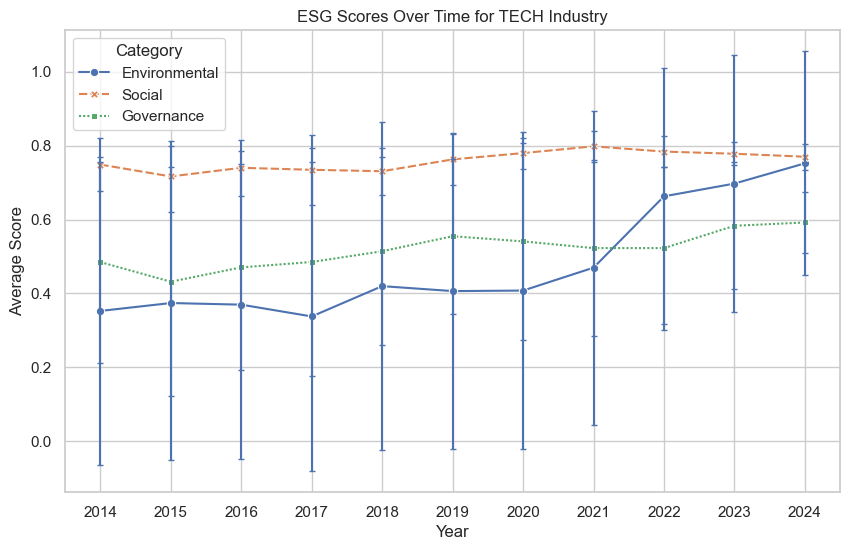

In [50]:
data = {
    "Year": list(target_years),
    "Environmental": environment_scores,
    "Environmental_SD": environment_stds,
    "Social": social_scores,
    "Social_SD": social_stds,
    "Governance": governance_scores,
    "Governance_SD": governance_stds
}

# Convert to a DataFrame for Seaborn compatibility
df = pd.DataFrame(data)

# Melt the DataFrame for easier plotting with Seaborn
df_melted = df.melt(
    id_vars=["Year"], 
    value_vars=["Environmental", "Social", "Governance"], 
    var_name="Category", 
    value_name="Score"
)

# Add a column for the corresponding standard deviations
std_melted = df.melt(
    id_vars=["Year"], 
    value_vars=["Environmental_SD", "Social_SD", "Governance_SD"], 
    var_name="Category", 
    value_name="Standard_Deviation"
)

# Match the SD values with the melted data
df_melted["Standard_Deviation"] = std_melted["Standard_Deviation"]

# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_melted, 
    x="Year", 
    y="Score", 
    hue="Category", 
    style="Category",
    markers=True,
    # err_style="bars",  # Show error bars
    errorbar=("ci", 0)  # Disable automatic confidence intervals (use provided SDs)
)

for category in df_melted["Category"].unique():
    subset = df_melted[df_melted["Category"] == category]
    plt.errorbar(
        subset["Year"], 
        subset["Score"], 
        yerr=subset["Standard_Deviation"], 
        fmt="none", 
        capsize=2, 
        label=None
    )

plt.xticks(ticks=df["Year"], labels=df["Year"])
plt.ylim(ymin, ymax)

plt.title(f"ESG Scores Over Time for {industry} Industry")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.legend(title="Category")
plt.show()

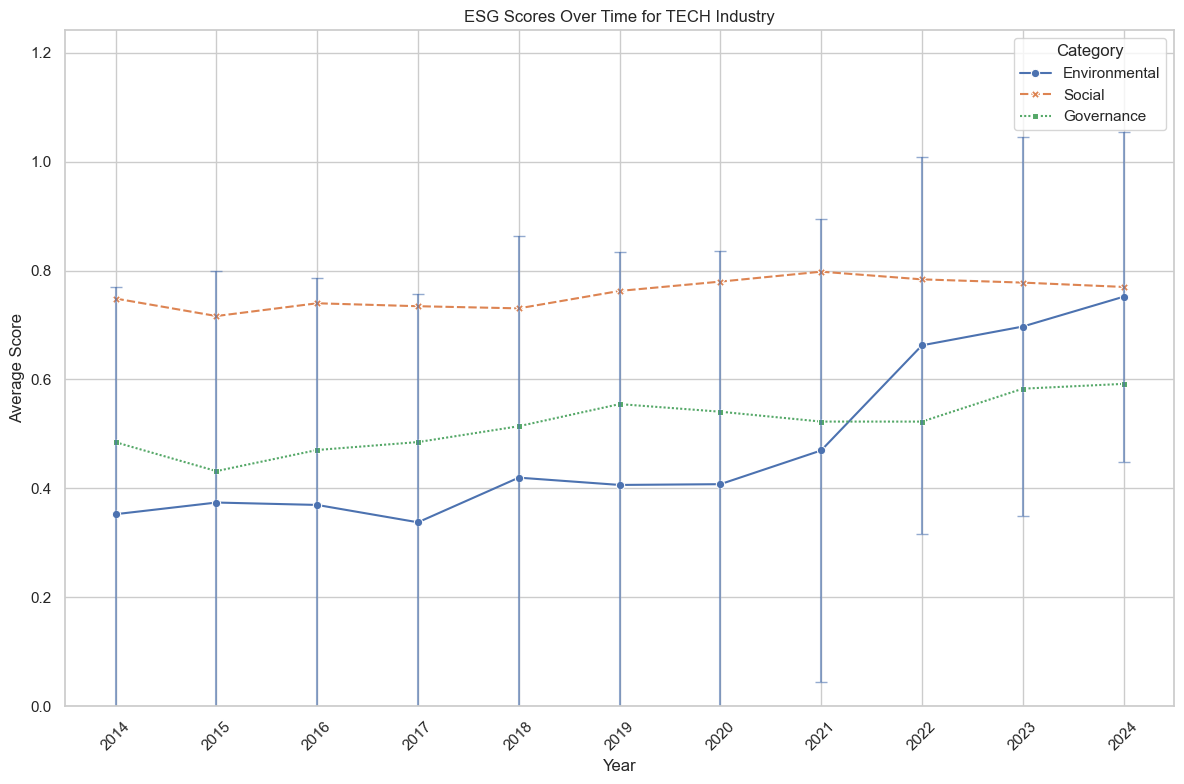

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming target_years, environment_scores, environment_stds, social_scores, social_stds,
# governance_scores, and governance_stds are already defined

# Prepare the data
data = {
    "Year": list(target_years),
    "Environmental": environment_scores,
    "Environmental_SD": environment_stds,
    "Social": social_scores,
    "Social_SD": social_stds,
    "Governance": governance_scores,
    "Governance_SD": governance_stds
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for easier plotting with Seaborn
df_melted = df.melt(
    id_vars=["Year"], 
    value_vars=["Environmental", "Social", "Governance"], 
    var_name="Category", 
    value_name="Score"
)

# Melt the standard deviations
std_melted = df.melt(
    id_vars=["Year"], 
    value_vars=["Environmental_SD", "Social_SD", "Governance_SD"], 
    var_name="Category", 
    value_name="Standard_Deviation"
)

# Map standard deviation values to the melted data
df_melted["Standard_Deviation"] = std_melted["Standard_Deviation"]

# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.lineplot(
    data=df_melted,
    x="Year",
    y="Score",
    hue="Category",
    style="Category",
    markers=True,
    errorbar=None  # Disable Seaborn's default error bars
)

# Add custom error bars using Matplotlib
# for category in df_melted["Category"].unique():
#     subset = df_melted[df_melted["Category"] == category]
#     plt.errorbar(
#         subset["Year"], 
#         subset["Score"], 
#         yerr=subset["Standard_Deviation"], 
#         fmt="none", 
#         capsize=4, 
#         label=None, 
#         alpha=0.6  # Add some transparency to the error bars
#     )

subset_env = df_melted[df_melted["Category"] == "Environmental"]
plt.errorbar(
    subset_env["Year"], 
    subset_env["Score"], 
    yerr=subset_env["Standard_Deviation"], 
    fmt="none", 
    capsize=4, 
    label=None, 
    alpha=0.6  # Add some transparency to the error bars
)

# Adjust y-axis if error bars are too large
all_scores = df_melted["Score"]
all_errors = df_melted["Standard_Deviation"].fillna(0)
ymin = max(0, all_scores.min() - all_errors.max())
ymax = all_scores.max() + all_errors.max()
plt.ylim(ymin, ymax)

plt.xticks(ticks=df["Year"].unique(), labels=df["Year"].unique(), rotation=45)
plt.title(f"ESG Scores Over Time for {industry} Industry")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.legend(title="Category")
plt.tight_layout()
plt.show()


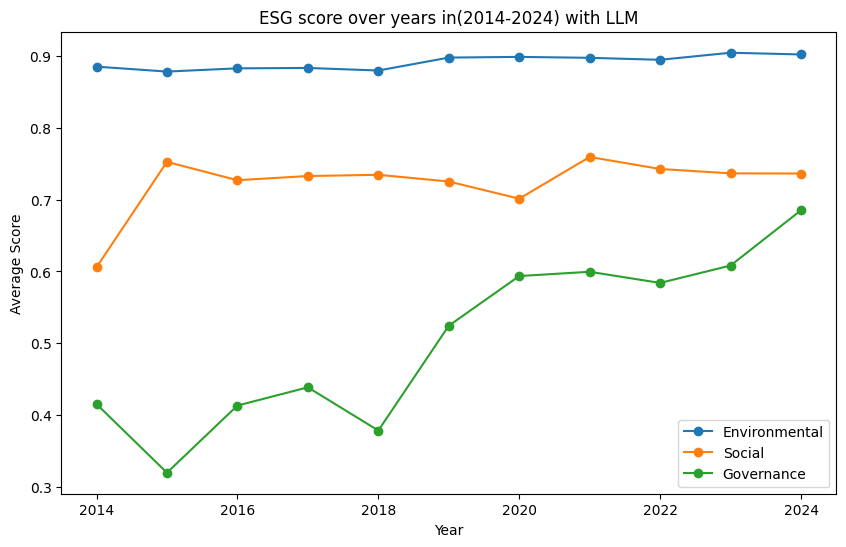

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(target_years, environment_scores, label='Environmental', marker='o')
plt.plot(target_years, social_scores, label='Social', marker='o')
plt.plot(target_years, governance_scores, label='Governance', marker='o')

plt.title("ESG score over years in (2014-2024) with LLM")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.legend()
plt.show()